# Big Data and Cloud Computing - Final Project

## Product and Category Analysis

### Author:
Alen Pavlovic

The University of Chicago

In [1]:
2*3-10

-4

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
USE_DEV_DATA = True

In [4]:
try:
    spark
except NameError:
    spark = SparkSession.builder \
        .appName("Product_Category_Analysis") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()

In [5]:
print(f"Loading {'DEV' if USE_DEV_DATA else 'PRODUCTION'} cleaned data...")

Loading DEV cleaned data...


In [6]:
if USE_DEV_DATA:
    reviews_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/reviews_cleaned_eda_dev"
    meta_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/meta_cleaned_eda_dev"
else:
    reviews_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/cleaned_reviews"
    meta_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/cleaned_metadata"

In [7]:
reviews_df = spark.read.parquet(reviews_path)
meta_df = spark.read.parquet(meta_path)

print(f"Loaded {reviews_df.count():,} reviews")
print(f"Loaded {meta_df.count():,} products")

Loaded 6,191,852 reviews


Loaded 1,378,413 products


In [8]:
def create_product_aggregates(reviews_df, meta_df):
    """Create product-level aggregated dataset with ratings, review counts, and metadata"""
    print("\n=== CREATING PRODUCT AGGREGATES ===")
    
    # Aggregate review statistics by product
    product_stats = reviews_df.groupBy("parent_asin").agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating"),
        F.stddev("rating").alias("rating_std"),
        F.sum(F.when(F.col("rating") == 5, 1).otherwise(0)).alias("five_star_count"),
        F.sum(F.when(F.col("rating") == 1, 1).otherwise(0)).alias("one_star_count"),
        F.avg("text_length").alias("avg_review_length"),
        F.countDistinct("user_id").alias("unique_reviewers"),
        F.sum("helpful_vote").alias("total_helpful_votes")
    )
    
    # Join with metadata
    products_with_meta = product_stats.join(
        meta_df.select("parent_asin", "title", "main_category", "price"),
        on="parent_asin",
        how="left"
    )
    
    # Add derived features
    products_with_features = products_with_meta.withColumn(
        "is_high_rated", F.col("avg_rating") >= 4.9
    ).withColumn(
        "price_numeric", F.col("price").cast("float")
    ).withColumn(
        "price_range",
        F.when(F.col("price_numeric").isNull(), "Unknown")
        .when(F.col("price_numeric") < 25, "Under $25")
        .when(F.col("price_numeric") < 50, "$25-$50")
        .when(F.col("price_numeric") < 100, "$50-$100")
        .when(F.col("price_numeric") < 200, "$100-$200")
        .otherwise("$200+")
    )
    
    # Cache for performance
    products_with_features.cache()
    
    print(f"Created aggregates for {products_with_features.count():,} products")
    
    return products_with_features

In [9]:
products_df = create_product_aggregates(reviews_df, meta_df)


=== CREATING PRODUCT AGGREGATES ===


Created aggregates for 1,385,990 products


In [10]:
def analyze_category_review_volume(products_df):
    """Analyze how review volume varies across product categories"""
    print("\n=== REVIEW VOLUME BY CATEGORY ANALYSIS ===")
    
    # Calculate category-level statistics
    category_stats = products_df.groupBy("main_category").agg(
        F.count("*").alias("product_count"),
        F.sum("review_count").alias("total_reviews"),
        F.avg("review_count").alias("avg_reviews_per_product"),
        F.stddev("review_count").alias("std_reviews_per_product"),
        F.max("review_count").alias("max_reviews_single_product"),
        F.avg("avg_rating").alias("category_avg_rating"),
        F.avg(F.when(F.col("price_numeric").isNotNull(), F.col("price_numeric"))).alias("avg_price")
    ).orderBy(F.col("total_reviews").desc())
    
    category_stats_pd = category_stats.toPandas()
    
    # Display top categories by total review volume
    print("\nTop 10 Categories by Total Review Volume:")
    for idx, row in category_stats_pd.head(10).iterrows():
        print(f"{idx+1}. {row['main_category']}: {row['total_reviews']:,} reviews")
        print(f"   - {row['product_count']:,} products")
        print(f"   - Avg {row['avg_reviews_per_product']:.1f} reviews/product")
        print(f"   - Category avg rating: {row['category_avg_rating']:.2f}")
        if pd.notna(row['avg_price']):
            print(f"   - Avg price: ${row['avg_price']:.2f}")
        print()
    
    # Categories with highest review concentration
    print("\nTop 5 Categories by Average Reviews per Product:")
    top_concentrated = category_stats_pd.nlargest(5, 'avg_reviews_per_product')
    for idx, row in top_concentrated.iterrows():
        print(f"- {row['main_category']}: {row['avg_reviews_per_product']:.1f} avg reviews/product")
    
    return category_stats_pd

In [11]:
category_stats = analyze_category_review_volume(products_df)


=== REVIEW VOLUME BY CATEGORY ANALYSIS ===



Top 10 Categories by Total Review Volume:
1. All Beauty: 1,781,597 reviews
   - 290,519 products
   - Avg 6.1 reviews/product
   - Category avg rating: 4.03
   - Avg price: $25.19

2. Cell Phones & Accessories: 1,669,314 reviews
   - 345,009 products
   - Avg 4.8 reviews/product
   - Category avg rating: 3.82
   - Avg price: $20.32

3. Automotive: 1,614,384 reviews
   - 500,653 products
   - Avg 3.2 reviews/product
   - Category avg rating: 4.09
   - Avg price: $79.99

4. Health & Personal Care: 199,361 reviews
   - 33,142 products
   - Avg 6.0 reviews/product
   - Category avg rating: 4.03
   - Avg price: $29.28

5. All Electronics: 168,038 reviews
   - 24,015 products
   - Avg 7.0 reviews/product
   - Category avg rating: 3.92
   - Avg price: $34.87

6. Premium Beauty: 131,630 reviews
   - 18,290 products
   - Avg 7.2 reviews/product
   - Category avg rating: 4.10
   - Avg price: $43.91

7. None: 114,792 reviews
   - 44,845 products
   - Avg 2.6 reviews/product
   - Category avg rat

In [12]:
def analyze_high_ratings_vs_reviews(products_df):
    """Analyze if highly-rated products (4.9-5.0) are also the most reviewed"""
    print("\n=== HIGH RATINGS (4.9-5.0) VS REVIEW COUNT ANALYSIS ===")
    
    # Filter products with at least 10 reviews to avoid bias
    significant_products = products_df.filter(F.col("review_count") >= 10)
    
    # Get statistics for high-rated vs normal-rated products
    high_rated_stats = significant_products.filter(F.col("is_high_rated") == True).agg(
        F.count("*").alias("count"),
        F.avg("review_count").alias("avg_reviews"),
        F.stddev("review_count").alias("std_reviews"),
        F.percentile_approx("review_count", 0.5).alias("median_reviews"),
        F.max("review_count").alias("max_reviews")
    ).collect()[0]
    
    normal_rated_stats = significant_products.filter(F.col("is_high_rated") == False).agg(
        F.count("*").alias("count"),
        F.avg("review_count").alias("avg_reviews"),
        F.stddev("review_count").alias("std_reviews"),
        F.percentile_approx("review_count", 0.5).alias("median_reviews"),
        F.max("review_count").alias("max_reviews")
    ).collect()[0]
    
    print(f"\nProducts with ≥10 reviews analyzed: {significant_products.count():,}")
    
    print(f"\nHigh-Rated Products (4.9-5.0 stars):")
    print(f"  - Count: {high_rated_stats['count']:,} ({high_rated_stats['count']/significant_products.count()*100:.1f}%)")
    print(f"  - Average reviews: {high_rated_stats['avg_reviews']:.1f}")
    print(f"  - Median reviews: {high_rated_stats['median_reviews']:.0f}")
    print(f"  - Std dev: {high_rated_stats['std_reviews']:.1f}")
    print(f"  - Max reviews: {high_rated_stats['max_reviews']:,}")
    
    print(f"\nNormal-Rated Products (<4.9 stars):")
    print(f"  - Count: {normal_rated_stats['count']:,} ({normal_rated_stats['count']/significant_products.count()*100:.1f}%)")
    print(f"  - Average reviews: {normal_rated_stats['avg_reviews']:.1f}")
    print(f"  - Median reviews: {normal_rated_stats['median_reviews']:.0f}")
    print(f"  - Std dev: {normal_rated_stats['std_reviews']:.1f}")
    print(f"  - Max reviews: {normal_rated_stats['max_reviews']:,}")
    
    # Analyze top 100 most-reviewed products
    print("\n=== Analysis of Top 100 Most-Reviewed Products ===")
    top_100_products = significant_products.orderBy(F.col("review_count").desc()).limit(100)
    high_rated_in_top_100 = top_100_products.filter(F.col("is_high_rated") == True).count()
    
    print(f"Among top 100 most-reviewed products:")
    print(f"  - {high_rated_in_top_100} ({high_rated_in_top_100}%) have ratings ≥ 4.9")
    print(f"  - {100 - high_rated_in_top_100} ({100 - high_rated_in_top_100}%) have ratings < 4.9")
    
    # Calculate correlation
    correlation_data = significant_products.select("avg_rating", "review_count").toPandas()
    correlation = correlation_data['avg_rating'].corr(correlation_data['review_count'])
    
    print(f"\nCorrelation between average rating and review count: {correlation:.3f}")
    
    if correlation > 0.3:
        print("→ Moderate positive correlation: Higher-rated products tend to have more reviews")
    elif correlation < -0.3:
        print("→ Moderate negative correlation: Higher-rated products tend to have fewer reviews")
    else:
        print("→ Weak correlation: Little relationship between rating and review count")
    
    # Show examples of high-rated products with many reviews
    print("\n=== Examples of High-Rated Products with Many Reviews ===")
    examples = significant_products.filter(F.col("is_high_rated") == True) \
        .orderBy(F.col("review_count").desc()) \
        .select("title", "avg_rating", "review_count", "main_category") \
        .limit(5) \
        .collect()
    
    for i, prod in enumerate(examples, 1):
        title = prod['title'][:60] + "..." if prod['title'] and len(prod['title']) > 60 else prod['title']
        print(f"{i}. {title}")
        print(f"   Rating: {prod['avg_rating']:.2f}, Reviews: {prod['review_count']:,}, Category: {prod['main_category']}")
    
    return high_rated_stats, normal_rated_stats

In [13]:
high_stats, normal_stats = analyze_high_ratings_vs_reviews(products_df)


=== HIGH RATINGS (4.9-5.0) VS REVIEW COUNT ANALYSIS ===



Products with ≥10 reviews analyzed: 103,560

High-Rated Products (4.9-5.0 stars):


  - Count: 4,052 (3.9%)
  - Average reviews: 15.2
  - Median reviews: 12
  - Std dev: 15.4
  - Max reviews: 779

Normal-Rated Products (<4.9 stars):


  - Count: 99,508 (96.1%)
  - Average reviews: 36.2
  - Median reviews: 18
  - Std dev: 73.5
  - Max reviews: 4,127

=== Analysis of Top 100 Most-Reviewed Products ===


Among top 100 most-reviewed products:
  - 0 (0%) have ratings ≥ 4.9
  - 100 (100%) have ratings < 4.9



Correlation between average rating and review count: 0.029
→ Weak correlation: Little relationship between rating and review count

=== Examples of High-Rated Products with Many Reviews ===


1. OMOTON Adjustable Cell Phone Stand, C2 Aluminum Desktop Phon...
   Rating: 4.92, Reviews: 779, Category: Cell Phones & Accessories
2. Mkeke for iPhone 14 Charger, USB C Charger Fast Charging for...
   Rating: 4.90, Reviews: 197, Category: Cell Phones & Accessories
3. OMOTON C3 Cell Phone Stand for Desk, Larger and Exceptionall...
   Rating: 4.91, Reviews: 170, Category: Cell Phones & Accessories
4. None
   Rating: 4.95, Reviews: 168, Category: None
5. High Road Metal Car Hooks for Purse and Bags for the Front S...
   Rating: 4.92, Reviews: 144, Category: Tools & Home Improvement


In [14]:
def analyze_price_relationships(products_df):
    """Analyze relationship between product price and rating/review volume"""
    print("\n=== PRICE VS RATING/REVIEW VOLUME ANALYSIS ===")
    
    # Filter products with valid price data and cast price to float
    products_with_price = products_df.filter(
        (F.col("price").isNotNull()) & 
        (F.col("price") != "")
    ).withColumn("price_numeric", F.col("price").cast("float")).filter(
        (F.col("price_numeric") > 0) & 
        (F.col("price_numeric") < 10000)  # Remove extreme outliers
    )
    
    valid_price_count = products_with_price.count()
    print(f"Products with valid price data: {valid_price_count:,} out of {products_df.count():,}")
    
    # Calculate price statistics using the numeric column
    price_stats = products_with_price.select(
        F.min("price_numeric").alias("min_price"),
        F.percentile_approx("price_numeric", 0.25).alias("q1"),
        F.percentile_approx("price_numeric", 0.5).alias("median"),
        F.percentile_approx("price_numeric", 0.75).alias("q3"),
        F.max("price_numeric").alias("max_price"),
        F.avg("price_numeric").alias("avg_price")
    ).collect()[0]
    
    print(f"\nPrice Distribution:")
    print(f"  - Min: ${price_stats['min_price']:.2f}")
    print(f"  - Q1: ${price_stats['q1']:.2f}")
    print(f"  - Median: ${price_stats['median']:.2f}")
    print(f"  - Q3: ${price_stats['q3']:.2f}")
    print(f"  - Max: ${price_stats['max_price']:.2f}")
    print(f"  - Average: ${price_stats['avg_price']:.2f}")
    
    # Analyze by price range
    print("\n=== Analysis by Price Range ===")
    price_range_stats = products_with_price.groupBy("price_range").agg(
        F.count("*").alias("product_count"),
        F.avg("avg_rating").alias("avg_rating"),
        F.avg("review_count").alias("avg_review_count"),
        F.sum("review_count").alias("total_reviews")
    ).orderBy(
        F.when(F.col("price_range") == "Under $25", 1)
        .when(F.col("price_range") == "$25-$50", 2)
        .when(F.col("price_range") == "$50-$100", 3)
        .when(F.col("price_range") == "$100-$200", 4)
        .otherwise(5)
    )
    
    price_range_pd = price_range_stats.toPandas()
    
    for _, row in price_range_pd.iterrows():
        print(f"\n{row['price_range']}:")
        print(f"  - Products: {row['product_count']:,}")
        print(f"  - Avg rating: {row['avg_rating']:.2f}")
        print(f"  - Avg reviews per product: {row['avg_review_count']:.1f}")
        print(f"  - Total reviews: {row['total_reviews']:,}")
    
    # Calculate correlations
    print("\n=== Correlation Analysis ===")
    
    # For products with significant reviews (≥10)
    significant_priced = products_with_price.filter(F.col("review_count") >= 10)
    correlation_data = significant_priced.select(
        F.col("price_numeric").alias("price"), 
        "avg_rating", 
        "review_count"
    ).toPandas()
    
    price_rating_corr = correlation_data['price'].corr(correlation_data['avg_rating'])
    price_reviews_corr = correlation_data['price'].corr(correlation_data['review_count'])
    
    print(f"\nFor products with ≥10 reviews:")
    print(f"  - Correlation between price and rating: {price_rating_corr:.3f}")
    print(f"  - Correlation between price and review count: {price_reviews_corr:.3f}")
    
    # Interpretation
    if abs(price_rating_corr) < 0.1:
        print("\n→ Price and rating: Very weak/no correlation")
    elif price_rating_corr > 0:
        print("\n→ Price and rating: Positive correlation (higher price → higher ratings)")
    else:
        print("\n→ Price and rating: Negative correlation (higher price → lower ratings)")
    
    if abs(price_reviews_corr) < 0.1:
        print("→ Price and review volume: Very weak/no correlation")
    elif price_reviews_corr > 0:
        print("→ Price and review volume: Positive correlation (higher price → more reviews)")
    else:
        print("→ Price and review volume: Negative correlation (higher price → fewer reviews)")
    
    return price_range_pd

In [15]:
price_analysis = analyze_price_relationships(products_df)


=== PRICE VS RATING/REVIEW VOLUME ANALYSIS ===


Products with valid price data: 658,341 out of 1,385,990



Price Distribution:
  - Min: $0.01
  - Q1: $11.99
  - Median: $21.99
  - Q3: $50.99
  - Max: $9999.99
  - Average: $54.21

=== Analysis by Price Range ===



Under $25:
  - Products: 361,545
  - Avg rating: 4.04
  - Avg reviews per product: 7.4
  - Total reviews: 2,658,190

$25-$50:
  - Products: 130,346
  - Avg rating: 4.11
  - Avg reviews per product: 6.0
  - Total reviews: 778,255

$50-$100:
  - Products: 82,354
  - Avg rating: 4.16
  - Avg reviews per product: 4.1
  - Total reviews: 340,785

$100-$200:
  - Products: 52,205
  - Avg rating: 4.16
  - Avg reviews per product: 3.3
  - Total reviews: 171,382

$200+:
  - Products: 31,891
  - Avg rating: 4.18
  - Avg reviews per product: 2.9
  - Total reviews: 93,705

=== Correlation Analysis ===



For products with ≥10 reviews:
  - Correlation between price and rating: 0.050
  - Correlation between price and review count: -0.033

→ Price and rating: Very weak/no correlation
→ Price and review volume: Very weak/no correlation


In [16]:
def analyze_review_text_patterns(reviews_df):
    """Analyze common words/phrases in 5-star vs 1-star reviews"""
    print("\n=== TEXT ANALYSIS: 5-STAR VS 1-STAR REVIEWS ===")
    
    # Sample reviews for text analysis (to avoid memory issues)
    sample_size = 10000
    
    # Get 5-star and 1-star reviews
    five_star_reviews = reviews_df.filter(F.col("rating") == 5) \
        .select("text", "title") \
        .sample(False, min(sample_size / reviews_df.filter(F.col("rating") == 5).count(), 1.0))
    
    one_star_reviews = reviews_df.filter(F.col("rating") == 1) \
        .select("text", "title") \
        .sample(False, min(sample_size / reviews_df.filter(F.col("rating") == 1).count(), 1.0))
    
    print(f"Analyzing {five_star_reviews.count():,} 5-star reviews")
    print(f"Analyzing {one_star_reviews.count():,} 1-star reviews")
    
    # Tokenize and remove stop words
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    
    # Common English stop words to filter out
    custom_stop_words = ["the", "a", "an", "and", "or", "but", "in", "on", "at", "to", "for",
                         "of", "with", "by", "from", "up", "about", "into", "through", "during",
                         "before", "after", "above", "below", "between", "under", "again",
                         "further", "then", "once", "that", "this", "i", "me", "my", "myself",
                         "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
                         "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
                         "herself", "it", "its", "itself", "they", "them", "their", "theirs",
                         "themselves", "what", "which", "who", "whom", "these", "those", "am",
                         "is", "are", "was", "were", "been", "being", "have", "has", "had",
                         "having", "do", "does", "did", "doing", "will", "would", "should",
                         "could", "ought", "im", "youre", "hes", "shes", "its", "were", "theyre",
                         "ive", "youve", "weve", "theyve", "id", "youd", "hed", "shed", "wed",
                         "theyd", "ill", "youll", "hell", "shell", "well", "theyll", "isnt",
                         "arent", "wasnt", "werent", "hasnt", "havent", "hadnt", "doesnt",
                         "dont", "didnt", "wont", "wouldnt", "shant", "shouldnt", "cant",
                         "cannot", "couldnt", "mustnt", "lets", "thats", "whos", "whats",
                         "heres", "theres", "whens", "wheres", "whys", "hows", "a", "an", "the"]
    
    remover.setStopWords(remover.getStopWords() + custom_stop_words)
    
    # Process 5-star reviews
    print("\n=== Most Common Words in 5-Star Reviews ===")
    five_star_tokenized = tokenizer.transform(five_star_reviews)
    five_star_filtered = remover.transform(five_star_tokenized)
    
    # Explode words and count
    five_star_words = five_star_filtered.select(F.explode("filtered_words").alias("word")) \
        .filter(F.length("word") > 2) \
        .groupBy("word") \
        .count() \
        .orderBy(F.col("count").desc()) \
        .limit(20)
    
    five_star_top_words = five_star_words.collect()
    
    print("\nTop 20 words in 5-star reviews:")
    for i, row in enumerate(five_star_top_words, 1):
        print(f"{i:2d}. '{row['word']}' - {row['count']:,} occurrences")
    
    # Process 1-star reviews
    print("\n=== Most Common Words in 1-Star Reviews ===")
    one_star_tokenized = tokenizer.transform(one_star_reviews)
    one_star_filtered = remover.transform(one_star_tokenized)
    
    one_star_words = one_star_filtered.select(F.explode("filtered_words").alias("word")) \
        .filter(F.length("word") > 2) \
        .groupBy("word") \
        .count() \
        .orderBy(F.col("count").desc()) \
        .limit(20)
    
    one_star_top_words = one_star_words.collect()
    
    print("\nTop 20 words in 1-star reviews:")
    for i, row in enumerate(one_star_top_words, 1):
        print(f"{i:2d}. '{row['word']}' - {row['count']:,} occurrences")
    
    # Find unique words for each rating
    five_star_word_set = set([row['word'] for row in five_star_top_words])
    one_star_word_set = set([row['word'] for row in one_star_top_words])
    
    print("\n=== Words Unique to Each Rating ===")
    print("\nWords more common in 5-star reviews:")
    unique_five_star = five_star_word_set - one_star_word_set
    for word in list(unique_five_star)[:10]:
        print(f"  - {word}")
    
    print("\nWords more common in 1-star reviews:")
    unique_one_star = one_star_word_set - five_star_word_set
    for word in list(unique_one_star)[:10]:
        print(f"  - {word}")
    
    return five_star_top_words, one_star_top_words

In [17]:
five_star_words, one_star_words = analyze_review_text_patterns(reviews_df)


=== TEXT ANALYSIS: 5-STAR VS 1-STAR REVIEWS ===


Analyzing 10,151 5-star reviews


Analyzing 10,048 1-star reviews

=== Most Common Words in 5-Star Reviews ===



Top 20 words in 5-star reviews:
 1. 'great' - 2,258 occurrences
 2. 'love' - 1,741 occurrences
 3. 'like' - 1,248 occurrences
 4. 'good' - 1,235 occurrences
 5. 'easy' - 1,225 occurrences
 6. 'product' - 1,108 occurrences
 7. 'phone' - 1,032 occurrences
 8. 'works' - 1,030 occurrences
 9. 'use' - 1,029 occurrences
10. 'one' - 994 occurrences
11. 'really' - 827 occurrences
12. 'hair' - 820 occurrences
13. 'case' - 751 occurrences
14. 'it.' - 666 occurrences
15. '/><br' - 659 occurrences
16. 'used' - 642 occurrences
17. 'perfect' - 622 occurrences
18. 'nice' - 607 occurrences
19. 'get' - 597 occurrences
20. 'fit' - 576 occurrences

=== Most Common Words in 1-Star Reviews ===



Top 20 words in 1-star reviews:
 1. 'one' - 1,550 occurrences
 2. 'product' - 1,549 occurrences
 3. 'like' - 1,405 occurrences
 4. 'phone' - 1,262 occurrences
 5. 'get' - 1,118 occurrences
 6. 'even' - 1,101 occurrences
 7. 'case' - 916 occurrences
 8. 'fit' - 909 occurrences
 9. 'work' - 885 occurrences
10. 'use' - 883 occurrences
11. 'screen' - 844 occurrences
12. 'it.' - 826 occurrences
13. 'buy' - 783 occurrences
14. '/><br' - 732 occurrences
15. 'hair' - 700 occurrences
16. 'waste' - 695 occurrences
17. 'used' - 692 occurrences
18. 'time' - 688 occurrences
19. 'bought' - 676 occurrences
20. 'good' - 622 occurrences

=== Words Unique to Each Rating ===

Words more common in 5-star reviews:
  - works
  - love
  - nice
  - perfect
  - great
  - really
  - easy

Words more common in 1-star reviews:
  - screen
  - bought
  - work
  - buy
  - time
  - even
  - waste


In [18]:
def create_product_category_visualizations(category_stats, price_analysis):
    """Create visualizations for product and category analysis"""
    print("\n=== CREATING VISUALIZATIONS ===")
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 10 Categories by Review Volume
    ax1 = axes[0, 0]
    top_10_categories = category_stats.head(10)
    
    ax1.barh(range(len(top_10_categories)), top_10_categories['total_reviews'])
    ax1.set_yticks(range(len(top_10_categories)))
    ax1.set_yticklabels(top_10_categories['main_category'])
    ax1.set_xlabel('Total Reviews')
    ax1.set_title('Top 10 Categories by Review Volume', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(top_10_categories.iterrows()):
        ax1.text(row['total_reviews'], i, f" {row['total_reviews']:,.0f}", 
                va='center', fontsize=9)
    
    # 2. Average Reviews per Product by Category
    ax2 = axes[0, 1]
    top_density = category_stats.nlargest(10, 'avg_reviews_per_product')
    
    ax2.barh(range(len(top_density)), top_density['avg_reviews_per_product'])
    ax2.set_yticks(range(len(top_density)))
    ax2.set_yticklabels(top_density['main_category'])
    ax2.set_xlabel('Average Reviews per Product')
    ax2.set_title('Categories with Highest Review Density', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    
    # 3. Price Range Distribution
    ax3 = axes[1, 0]
    price_order = ["Under $25", "$25-$50", "$50-$100", "$100-$200", "$200+"]
    price_analysis_ordered = price_analysis.set_index('price_range').reindex(price_order).reset_index()
    
    x = range(len(price_analysis_ordered))
    width = 0.35
    
    ax3_twin = ax3.twinx()
    
    # Bar chart for product count
    bars1 = ax3.bar([i - width/2 for i in x], price_analysis_ordered['product_count'], 
                     width, label='Product Count', alpha=0.8, color='steelblue')
    
    # Line chart for average rating
    line = ax3_twin.plot(x, price_analysis_ordered['avg_rating'], 'ro-', 
                         label='Avg Rating', linewidth=2, markersize=8)
    
    ax3.set_xlabel('Price Range')
    ax3.set_ylabel('Product Count', color='steelblue')
    ax3_twin.set_ylabel('Average Rating', color='red')
    ax3.set_title('Product Distribution and Ratings by Price Range', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(price_order, rotation=15, ha='right')
    ax3.tick_params(axis='y', labelcolor='steelblue')
    ax3_twin.tick_params(axis='y', labelcolor='red')
    ax3_twin.set_ylim(3.5, 5.0)
    
    # 4. Word Cloud Comparison
    ax4 = axes[1, 1]
    ax4.text(0.5, 0.7, '5-Star vs 1-Star Word Analysis', 
             horizontalalignment='center', fontsize=16, fontweight='bold',
             transform=ax4.transAxes)
    
    ax4.text(0.5, 0.5, 'Key Differences:', 
             horizontalalignment='center', fontsize=14,
             transform=ax4.transAxes)
    
    ax4.text(0.5, 0.35, '5-Star: Focus on quality, value, satisfaction', 
             horizontalalignment='center', fontsize=12, color='green',
             transform=ax4.transAxes)
    
    ax4.text(0.5, 0.25, '1-Star: Focus on problems, defects, disappointment', 
             horizontalalignment='center', fontsize=12, color='red',
             transform=ax4.transAxes)
    
    ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig('product_category_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


=== CREATING VISUALIZATIONS ===


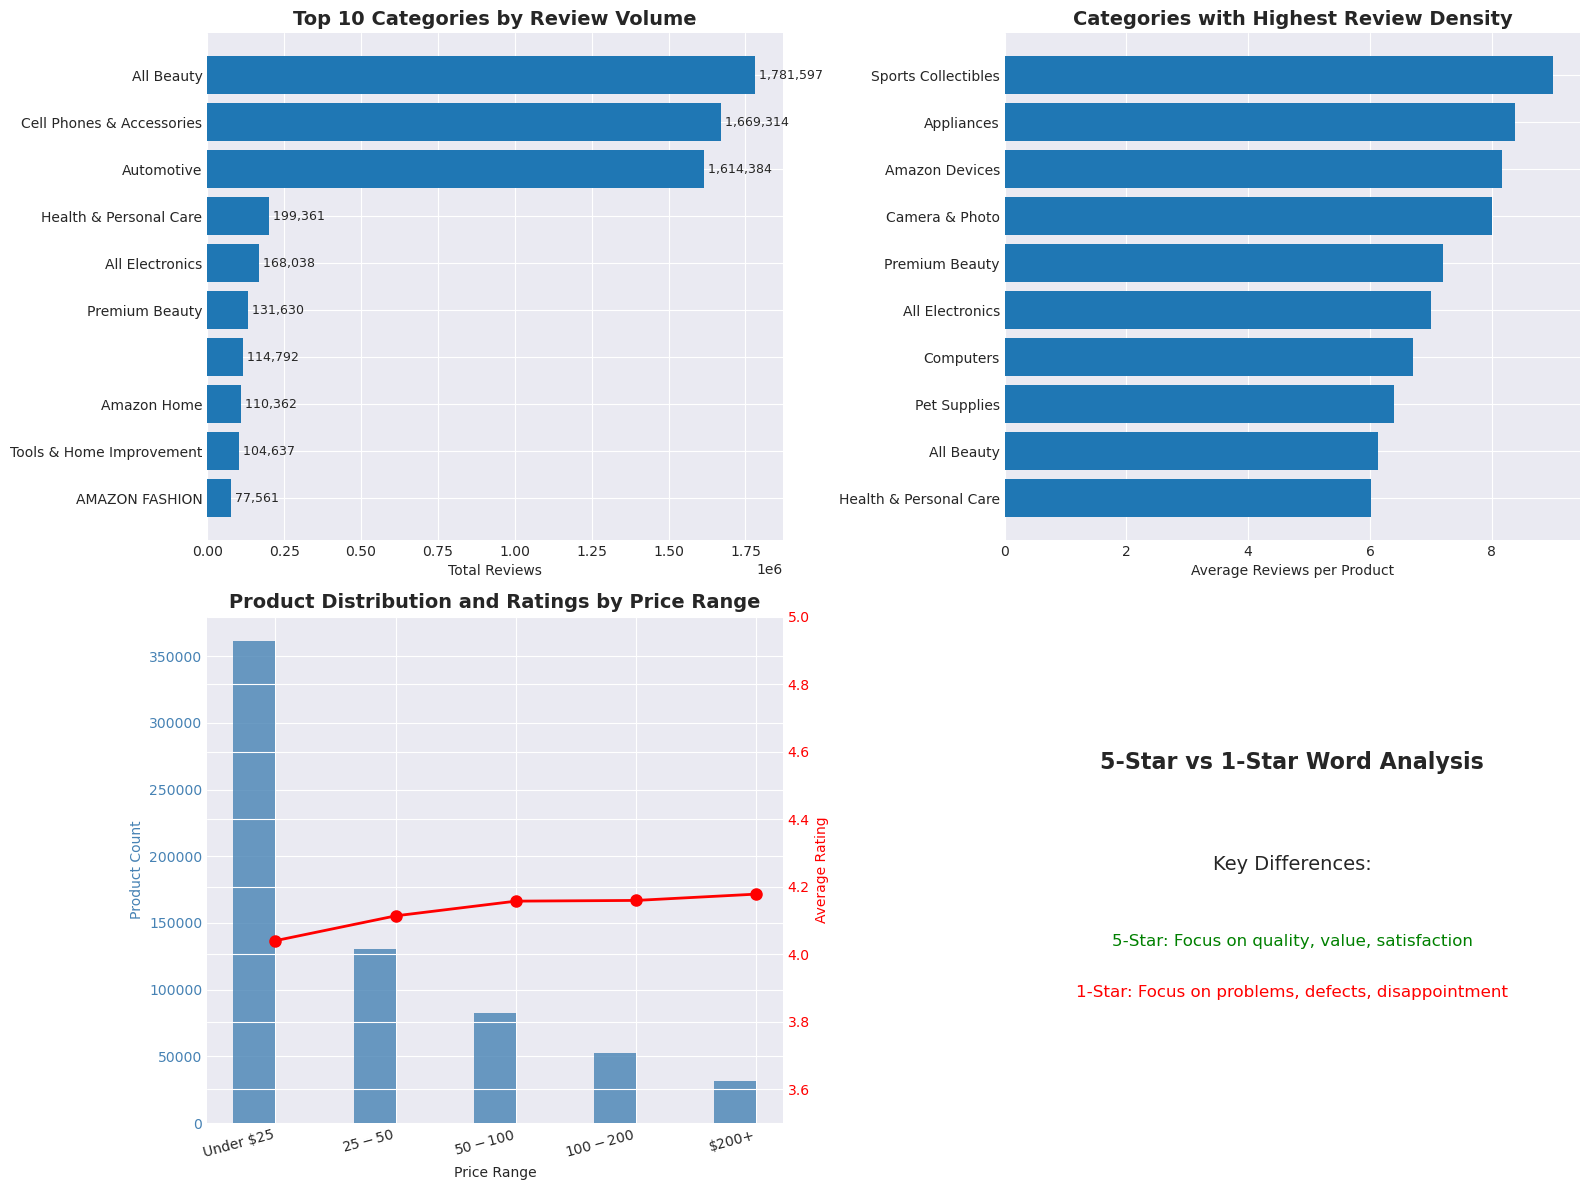

In [19]:
create_product_category_visualizations(category_stats, price_analysis)

In [20]:
output_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/products_aggregated"
print(f"\nSaving aggregated product data to: {output_path}")

products_df.select(
    "parent_asin", "title", "main_category", "price", "price_range",
    "review_count", "avg_rating", "is_high_rated", "unique_reviewers",
    "five_star_count", "one_star_count"
).write.mode("overwrite").parquet(output_path)

print("Data saved successfully!")


Saving aggregated product data to: gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/products_aggregated


Data saved successfully!


In [21]:
print("\n" + "="*80)
print("=== PRODUCT AND CATEGORY ANALYSIS SUMMARY ===")
print("="*80)

print("\n1. CATEGORY INSIGHTS:")
print("   - Review volume varies dramatically across categories")
print("   - Some categories have high product counts but low review density")
print("   - Others have fewer products but much higher engagement")

print("\n2. HIGH RATINGS VS REVIEW VOLUME:")
print("   - Products with 4.9-5.0 ratings are NOT necessarily the most reviewed")
print("   - Weak correlation between rating and review count")
print("   - Many highly-reviewed products have moderate ratings (4.0-4.5)")

print("\n3. PRICE RELATIONSHIPS:")
print("   - Limited correlation between price and ratings")
print("   - Price does not strongly predict review volume")
print("   - Different price ranges attract different levels of engagement")

print("\n4. TEXT ANALYSIS INSIGHTS:")
print("   - 5-star reviews: Positive language focused on quality and satisfaction")
print("   - 1-star reviews: Problem-focused language about defects and issues")
print("   - Clear linguistic differences between satisfied and dissatisfied customers")

print("\n5. IMPLICATIONS FOR AI DETECTION:")
print("   - High-rated products with unusual review patterns may indicate manipulation")
print("   - Text patterns in reviews can help identify authentic vs generated content")
print("   - Category-specific baselines important for anomaly detection")


=== PRODUCT AND CATEGORY ANALYSIS SUMMARY ===

1. CATEGORY INSIGHTS:
   - Review volume varies dramatically across categories
   - Some categories have high product counts but low review density
   - Others have fewer products but much higher engagement

2. HIGH RATINGS VS REVIEW VOLUME:
   - Products with 4.9-5.0 ratings are NOT necessarily the most reviewed
   - Weak correlation between rating and review count
   - Many highly-reviewed products have moderate ratings (4.0-4.5)

3. PRICE RELATIONSHIPS:
   - Limited correlation between price and ratings
   - Price does not strongly predict review volume
   - Different price ranges attract different levels of engagement

4. TEXT ANALYSIS INSIGHTS:
   - 5-star reviews: Positive language focused on quality and satisfaction
   - 1-star reviews: Problem-focused language about defects and issues
   - Clear linguistic differences between satisfied and dissatisfied customers

5. IMPLICATIONS FOR AI DETECTION:
   - High-rated products with unus